# **Histopathologic Cancer Detection**

In [ ]:
import numpy as np
import pandas as pd

import timm
import random
import os
base_dir = '../input/histopathologic-cancer-detection/'
print(os.listdir(base_dir))

# Matplotlib and Seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torchvision
import torch.optim as optim

# Import useful sklearn functions
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
)
from PIL import Image
from tqdm import tqdm

**Data Preprocessing**

In [2]:
# Data paths
train_path = '../input/histopathologic-cancer-detection/train/'
test_path = '../input/histopathologic-cancer-detection/test/'

In [3]:
# Read CSV file
train_df = pd.read_csv("../input/histopathologic-cancer-train-test-index/train_split.csv")
test_df = pd.read_csv("../input/histopathologic-cancer-train-test-index/test_split.csv")

In [10]:
# Customize class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir='./', transform=None):
        super().__init__()
        self.df = df_data.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name, label = self.df.iloc[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image {img_path} not found.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [5]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [7]:
batch_size = 128    # Set Batch Size
valid_size = 0.2    # Percentage of training set to use as validation

num_train = len(train_data)  
train_size = int((1 - valid_size) * num_train)  
valid_size = num_train - train_size  

train_data, valid_data = random_split(train_data, [train_size, valid_size])

# Prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

In [13]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Creating test data
test_data = CreateDataset(df_data=test_df, data_dir=train_path, transform=transforms_test)

# Prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

**Defining Model Architecture**

In [2]:
def build_vit_partial_finetune(num_classes=1, freeze_until=6):
    """
    Load pretrained vit_small_patch16_224 and apply partial fine-tuning:
      - Freeze patch embedding + các block đầu.
      - Fine-tune các block cuối cùng + classification head.

    Args:
        num_classes: số class output (1 cho binary classification)
        freeze_until: số block encoder đầu tiên cần freeze (0–11 cho ViT-B/16)
    """
    model = timm.create_model("vit_small_patch16_224", pretrained=True)

    # Lấy danh sách tất cả encoder blocks
    encoder_blocks = model.blocks

    # Freeze patch embedding
    for param in model.patch_embed.parameters():
        param.requires_grad = False
    model.cls_token.requires_grad = False
    model.pos_embed.requires_grad = False

    # Freeze các block encoder đầu
    for i, block in enumerate(encoder_blocks):
        if i < freeze_until:
            for param in block.parameters():
                param.requires_grad = False

    # Replace classification head
    in_features = model.head.in_features
    model.head = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes),
        nn.Sigmoid() if num_classes == 1 else nn.Softmax(dim=1)
    )

    return model

In [10]:
# Create a complete CNN
model = build_vit_partial_finetune(num_classes=1, freeze_until=6)
print(model)

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

Training on cuda


In [12]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
10746369


**Training Model**

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50):
    """ 
    Train & validate a PyTorch model 
        Args: 
            model : CNN model 
            train_loader: DataLoader cho tập train 
            val_loader : DataLoader cho tập validation 
            criterion : Loss function (nn.BCELoss hoặc nn.CrossEntropyLoss) 
            optimizer : Optimizer (Adam, SGD,...) 
            device : 'cuda' hoặc 'cpu' 
            num_epochs : số epoch huấn luyện 
        Returns: 
            model : mô hình sau khi train 
            history : dict chứa loss/acc theo epoch 
    """
    
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_auc": [],
        "val_auc": []
    }
    
    best_val_loss = float("inf")
    best_model_wts = model.state_dict()
    
    model.to(device)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)
        
        # ------------------------
        # TRAINING PHASE
        # ------------------------
        model.train()
        running_loss, total = 0.0, 0
        all_labels, all_outputs = [], []

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(images).squeeze()   # đã sigmoid rồi
            loss = criterion(outputs, labels.float())

            all_outputs.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            total += labels.size(0)
        
        epoch_train_loss = running_loss / total
        try:
            epoch_train_auc = roc_auc_score(all_labels, all_outputs)
        except ValueError:
            epoch_train_auc = 0.0

        # ------------------------
        # VALIDATION PHASE
        # ------------------------
        model.eval()
        val_loss, val_total = 0.0, 0
        val_labels, val_outputs = [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images).squeeze() 
                loss = criterion(outputs, labels.float())

                val_outputs.extend(outputs.detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())
                
                val_loss += loss.item() * images.size(0)
                val_total += labels.size(0)
        
        epoch_val_loss = val_loss / val_total
        try:
            epoch_val_auc = roc_auc_score(val_labels, val_outputs)
        except ValueError:
            epoch_val_auc = 0.0

        # ------------------------
        # LOGGING
        # ------------------------
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_auc"].append(epoch_train_auc)
        history["val_auc"].append(epoch_val_auc)

        print(f"Train Loss: {epoch_train_loss:.4f} AUC: {epoch_train_auc:.4f}")
        print(f"Valid Loss: {epoch_val_loss:.4f} AUC: {epoch_val_auc:.4f}")
        
        # ------------------------
        # SAVE BEST MODEL (theo val_loss nhỏ nhất)
        # ------------------------
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, "best_model.pth")
            print(">>> Saved best model with Val Loss:", best_val_loss)
    
    # load best weights
    model.load_state_dict(best_model_wts)
    return model, history

In [14]:
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

In [15]:
model, history = train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=30)


Epoch 1/30
------------------------------


Validation: 100%|██████████| 251/251 [07:25<00:00,  1.78s/it]


Train Loss: 0.1916 AUC: 0.9766
Valid Loss: 0.2092 AUC: 0.9854
>>> Saved best model with Val Loss: 0.2091762348730466

Epoch 2/30
------------------------------


Validation: 100%|██████████| 251/251 [03:01<00:00,  1.38it/s]


Train Loss: 0.1339 AUC: 0.9881
Valid Loss: 0.1268 AUC: 0.9896
>>> Saved best model with Val Loss: 0.12681811910294713

Epoch 3/30
------------------------------


Validation: 100%|██████████| 251/251 [03:04<00:00,  1.36it/s]


Train Loss: 0.1111 AUC: 0.9916
Valid Loss: 0.1137 AUC: 0.9918
>>> Saved best model with Val Loss: 0.11373271591933479

Epoch 4/30
------------------------------


Validation: 100%|██████████| 251/251 [03:29<00:00,  1.20it/s]


Train Loss: 0.0956 AUC: 0.9937
Valid Loss: 0.1040 AUC: 0.9929
>>> Saved best model with Val Loss: 0.1039508528840006

Epoch 5/30
------------------------------


Validation: 100%|██████████| 251/251 [03:02<00:00,  1.38it/s]


Train Loss: 0.0827 AUC: 0.9953
Valid Loss: 0.0948 AUC: 0.9937
>>> Saved best model with Val Loss: 0.09480929108994655

Epoch 6/30
------------------------------


Validation: 100%|██████████| 251/251 [03:01<00:00,  1.38it/s]


Train Loss: 0.0744 AUC: 0.9962
Valid Loss: 0.1067 AUC: 0.9929

Epoch 7/30
------------------------------


Validation: 100%|██████████| 251/251 [03:02<00:00,  1.37it/s]


Train Loss: 0.0668 AUC: 0.9969
Valid Loss: 0.0923 AUC: 0.9940
>>> Saved best model with Val Loss: 0.09229605314455526

Epoch 8/30
------------------------------


Validation: 100%|██████████| 251/251 [03:10<00:00,  1.32it/s]


Train Loss: 0.0609 AUC: 0.9974
Valid Loss: 0.0952 AUC: 0.9940

Epoch 9/30
------------------------------


Validation: 100%|██████████| 251/251 [03:05<00:00,  1.36it/s]


Train Loss: 0.0553 AUC: 0.9979
Valid Loss: 0.0983 AUC: 0.9945

Epoch 10/30
------------------------------


Validation: 100%|██████████| 251/251 [03:05<00:00,  1.35it/s]


Train Loss: 0.0511 AUC: 0.9982
Valid Loss: 0.0894 AUC: 0.9953
>>> Saved best model with Val Loss: 0.08937284476896945

Epoch 11/30
------------------------------


Validation: 100%|██████████| 251/251 [03:03<00:00,  1.37it/s]


Train Loss: 0.0472 AUC: 0.9984
Valid Loss: 0.0875 AUC: 0.9950
>>> Saved best model with Val Loss: 0.08751572509285774

Epoch 12/30
------------------------------


Validation: 100%|██████████| 251/251 [03:07<00:00,  1.34it/s]


Train Loss: 0.0421 AUC: 0.9988
Valid Loss: 0.0888 AUC: 0.9950

Epoch 13/30
------------------------------


Validation: 100%|██████████| 251/251 [03:06<00:00,  1.35it/s]


Train Loss: 0.0394 AUC: 0.9990
Valid Loss: 0.0901 AUC: 0.9954

Epoch 14/30
------------------------------


Validation: 100%|██████████| 251/251 [03:06<00:00,  1.35it/s]


Train Loss: 0.0354 AUC: 0.9991
Valid Loss: 0.0878 AUC: 0.9957

Epoch 15/30
------------------------------


Validation: 100%|██████████| 251/251 [03:07<00:00,  1.34it/s]


Train Loss: 0.0338 AUC: 0.9992
Valid Loss: 0.0861 AUC: 0.9955
>>> Saved best model with Val Loss: 0.08614568392212471

Epoch 16/30
------------------------------


Validation: 100%|██████████| 251/251 [03:03<00:00,  1.37it/s]


Train Loss: 0.0322 AUC: 0.9993
Valid Loss: 0.0989 AUC: 0.9952

Epoch 17/30
------------------------------


Validation: 100%|██████████| 251/251 [03:00<00:00,  1.39it/s]


Train Loss: 0.0302 AUC: 0.9994
Valid Loss: 0.0855 AUC: 0.9956
>>> Saved best model with Val Loss: 0.08551756116339516

Epoch 18/30
------------------------------


Validation: 100%|██████████| 251/251 [03:26<00:00,  1.21it/s]


Train Loss: 0.0281 AUC: 0.9994
Valid Loss: 0.0976 AUC: 0.9953

Epoch 19/30
------------------------------


Validation: 100%|██████████| 251/251 [03:07<00:00,  1.34it/s]


Train Loss: 0.0278 AUC: 0.9994
Valid Loss: 0.0991 AUC: 0.9959

Epoch 20/30
------------------------------


Validation: 100%|██████████| 251/251 [03:05<00:00,  1.35it/s]


Train Loss: 0.0250 AUC: 0.9996
Valid Loss: 0.0962 AUC: 0.9958

Epoch 21/30
------------------------------


Validation: 100%|██████████| 251/251 [03:03<00:00,  1.37it/s]


Train Loss: 0.0241 AUC: 0.9996
Valid Loss: 0.1014 AUC: 0.9953

Epoch 22/30
------------------------------


Validation: 100%|██████████| 251/251 [03:08<00:00,  1.33it/s]


Train Loss: 0.0225 AUC: 0.9996
Valid Loss: 0.0941 AUC: 0.9957

Epoch 23/30
------------------------------


Validation: 100%|██████████| 251/251 [03:04<00:00,  1.36it/s]


Train Loss: 0.0227 AUC: 0.9996
Valid Loss: 0.1075 AUC: 0.9951

Epoch 24/30
------------------------------


Validation: 100%|██████████| 251/251 [03:06<00:00,  1.35it/s]


Train Loss: 0.0210 AUC: 0.9997
Valid Loss: 0.1057 AUC: 0.9955

Epoch 25/30
------------------------------


Validation: 100%|██████████| 251/251 [03:08<00:00,  1.33it/s]


Train Loss: 0.0208 AUC: 0.9997
Valid Loss: 0.0866 AUC: 0.9956

Epoch 26/30
------------------------------


Validation: 100%|██████████| 251/251 [03:08<00:00,  1.33it/s]


Train Loss: 0.0185 AUC: 0.9998
Valid Loss: 0.0977 AUC: 0.9953

Epoch 27/30
------------------------------


Validation: 100%|██████████| 251/251 [03:03<00:00,  1.37it/s]


Train Loss: 0.0191 AUC: 0.9997
Valid Loss: 0.0878 AUC: 0.9961

Epoch 28/30
------------------------------


Validation: 100%|██████████| 251/251 [03:07<00:00,  1.34it/s]


Train Loss: 0.0182 AUC: 0.9998
Valid Loss: 0.0969 AUC: 0.9961

Epoch 29/30
------------------------------


Validation: 100%|██████████| 251/251 [03:00<00:00,  1.39it/s]


Train Loss: 0.0173 AUC: 0.9998
Valid Loss: 0.1005 AUC: 0.9959

Epoch 30/30
------------------------------


Validation: 100%|██████████| 251/251 [02:57<00:00,  1.41it/s]

Train Loss: 0.0169 AUC: 0.9998
Valid Loss: 0.1000 AUC: 0.9958


In [16]:
import pickle

with open("train_history.pkl", "wb") as f:
    pickle.dump(history, f)

In [17]:
def plot_history(history):
    # Plot loss
    plt.figure(figsize=(10,5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.show()

In [18]:
def evaluate_model(model, data_loader, device, threshold=None, min_tpr=0.95, tune_threshold=True):
    """
    Evaluate model trên tập dữ liệu và (tuỳ chọn) tự động tìm threshold tốt nhất
    theo tiêu chí Recall (TPR) ưu tiên.
    
    Args:
        model : mô hình đã huấn luyện
        data_loader : DataLoader cho tập validation/test
        device : 'cuda' hoặc 'cpu'
        threshold : threshold cố định (nếu không muốn auto-tune)
        min_tpr : ngưỡng tối thiểu của Recall khi tune threshold
        tune_threshold : nếu True -> tự động tìm threshold tối ưu theo Recall

    Returns:
        metrics : dict chứa kết quả đánh giá
    """
    model.eval()
    y_true, y_probs = [], []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            
            # Nếu model cuối có Sigmoid rồi thì bỏ sigmoid ở đây
            if logits.shape[-1] == 1:
                probs = logits.squeeze().detach().cpu().numpy()
            else:
                probs = torch.sigmoid(logits).squeeze().detach().cpu().numpy()

            y_probs.extend(probs)
            y_true.extend(yb.cpu().numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)

    # =====================
    # 1️⃣ Tune threshold nếu bật
    # =====================
    if tune_threshold:
        fpr, tpr, thresholds = roc_curve(y_true, y_probs)
        valid_idx = np.where(tpr >= min_tpr)[0]

        if len(valid_idx) == 0:
            print(f"⚠️ Không có threshold nào đạt TPR >= {min_tpr}. Sẽ chọn threshold với TPR cao nhất.")
            best_idx = np.argmax(tpr)
        else:
            best_idx = valid_idx[np.argmin(fpr[valid_idx])]

        threshold = thresholds[best_idx]
        print(f"\n🔍 Tuning threshold (TPR priority): {threshold:.4f}")
        print(f"TPR={tpr[best_idx]:.4f}, FPR={fpr[best_idx]:.4f}")

    elif threshold is None:
        threshold = 0.5  # Mặc định

    # =====================
    # 2️⃣ Áp dụng threshold để tính metric
    # =====================
    y_pred = (y_probs >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_probs)
    except ValueError:
        auc = None

    report = classification_report(y_true, y_pred, digits=4)
    cm = confusion_matrix(y_true, y_pred)

    print("\n=== Evaluation Report ===")
    print(f"Accuracy : {acc:.4f}")
    if auc is not None:
        print(f"ROC AUC  : {auc:.4f}")
    print(f"Threshold: {threshold:.4f}")
    print("\nClassification Report:\n", report)

    # =====================
    # 3️⃣ Confusion Matrix
    # =====================
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold={threshold:.3f})")
    plt.show()

    # =====================
    # 4️⃣ ROC Curve
    # =====================
    if auc is not None:
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

    return {
        "accuracy": acc,
        "auc": auc,
        "report": report,
        "confusion_matrix": cm,
        "threshold": threshold
    }

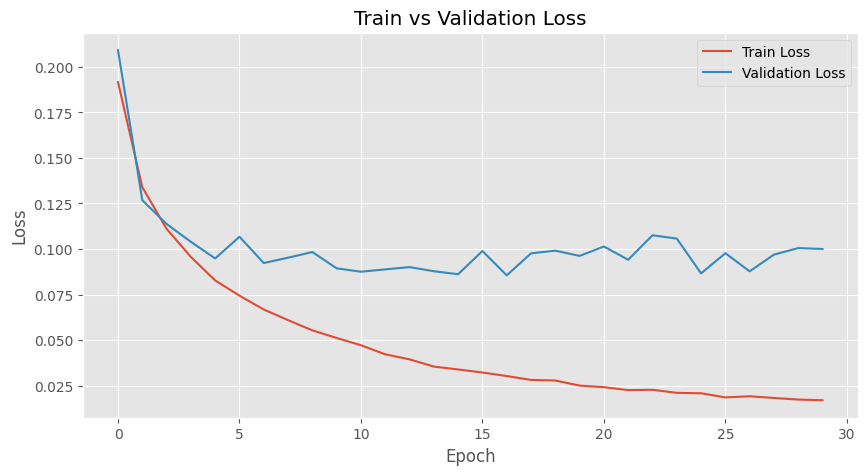

In [19]:
%matplotlib inline
plot_history(history)


🔍 Tuning threshold (TPR priority): 0.9652
TPR=0.9509, FPR=0.0081

=== Evaluation Report ===
Accuracy : 0.9714
ROC AUC  : 0.9966
Threshold: 0.9652

Classification Report:
               precision    recall  f1-score   support

           0     0.9528    0.9919    0.9720      8900
           1     0.9916    0.9509    0.9708      8900

    accuracy                         0.9714     17800
   macro avg     0.9722    0.9714    0.9714     17800
weighted avg     0.9722    0.9714    0.9714     17800



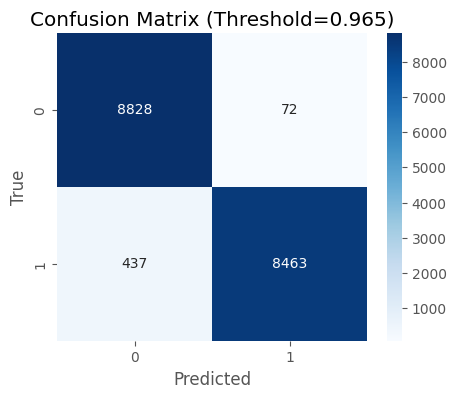

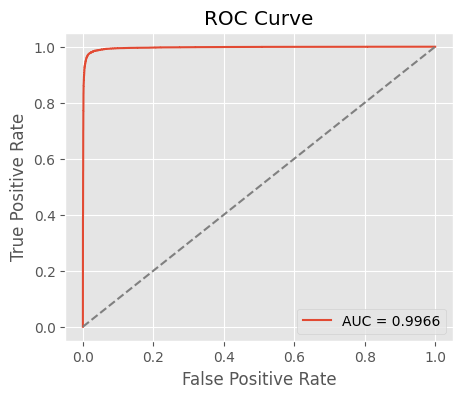

In [20]:
test_results = evaluate_model(
    model,
    test_loader,
    device,
    tune_threshold=True,
    min_tpr=0.95
)

In [ ]:
# Read best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_vit_partial_finetune(num_classes=1, freeze_until=6)
model.load_state_dict(torch.load("results (1)/best_model_ViT.pth"))
model.to(device)

In [ ]:
def get_attention_map(model, x, device):
    attn_maps = []

    def hook_fn(module, input, output):
        qkv = module.qkv(input[0])  # (B, N, 3*dim)
        B, N, _ = qkv.shape
        qkv = qkv.reshape(B, N, 3, module.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)  # (B, num_heads, N, N)
        attn_maps.append(attn.detach().cpu())

    handle = model.blocks[-1].attn.register_forward_hook(hook_fn)

    with torch.no_grad():
        _ = model(x.to(device))

    handle.remove()

    return attn_maps[0]


def visualize_attention(image_tensor, attn_map, index=0):
    """
    Hiển thị ảnh gốc và attention map cạnh nhau (không dùng skimage).
    """
    # Chuyển ảnh về numpy [H, W, C]
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    # Trung bình attention theo heads
    attn_mean = attn_map.mean(dim=1).squeeze(0)  # (N, N)
    attn_img = attn_mean[0, 1:].reshape(14, 14)  # (14, 14)
    attn_img = (attn_img - attn_img.min()) / (attn_img.max() - attn_img.min())

    # Resize bằng torch (interpolate)
    attn_tensor = torch.tensor(attn_img).unsqueeze(0).unsqueeze(0)  # (1,1,14,14)
    attn_resized = F.interpolate(attn_tensor, size=image.shape[:2], mode="bilinear", align_corners=False)
    attn_resized = attn_resized.squeeze().cpu().numpy()

    # Vẽ side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image)
    axs[0].axis('off')
    axs[0].set_title("Original Image")

    axs[1].imshow(attn_resized, cmap='jet')
    axs[1].axis('off')
    axs[1].set_title("Attention Map")

    plt.suptitle(f"Attention Visualization #{index}", fontsize=14)
    plt.tight_layout()
    plt.show()

C:\Users\pv\AppData\Local\Temp\ipykernel_25352\1600830978.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attn_tensor = torch.tensor(attn_img).unsqueeze(0).unsqueeze(0)  # (1,1,14,14)


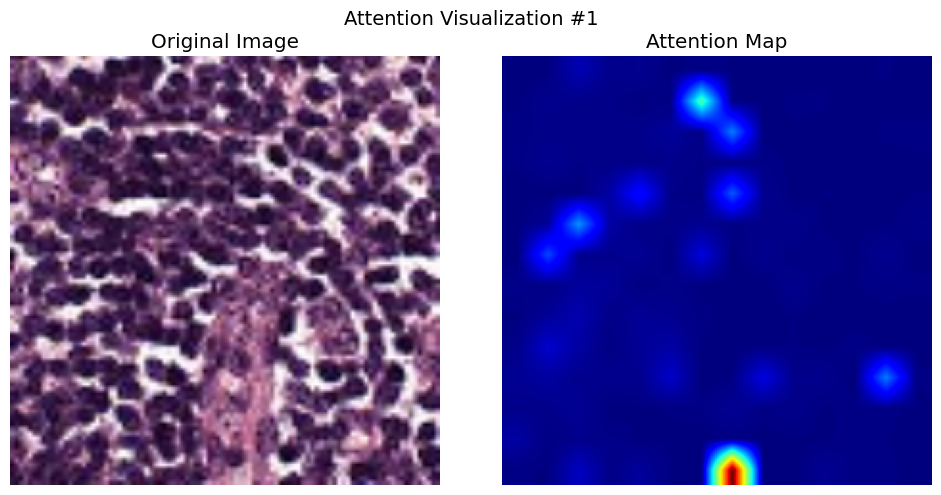

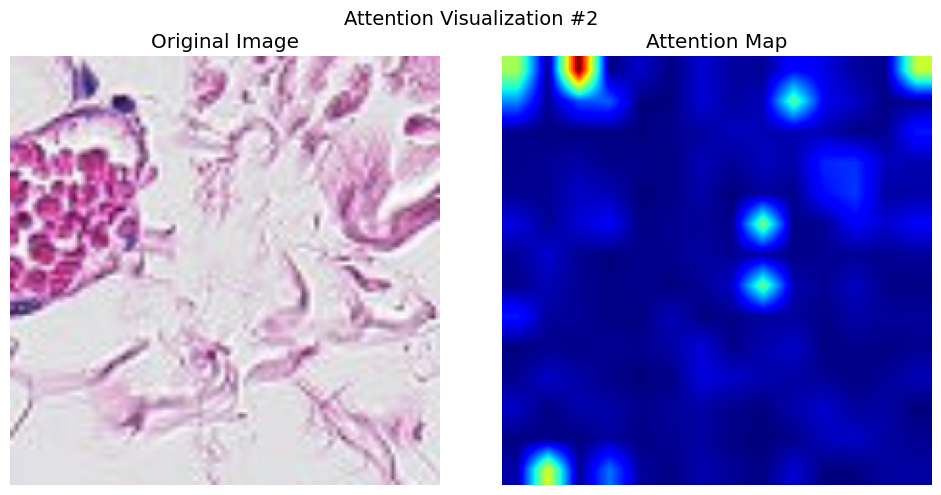

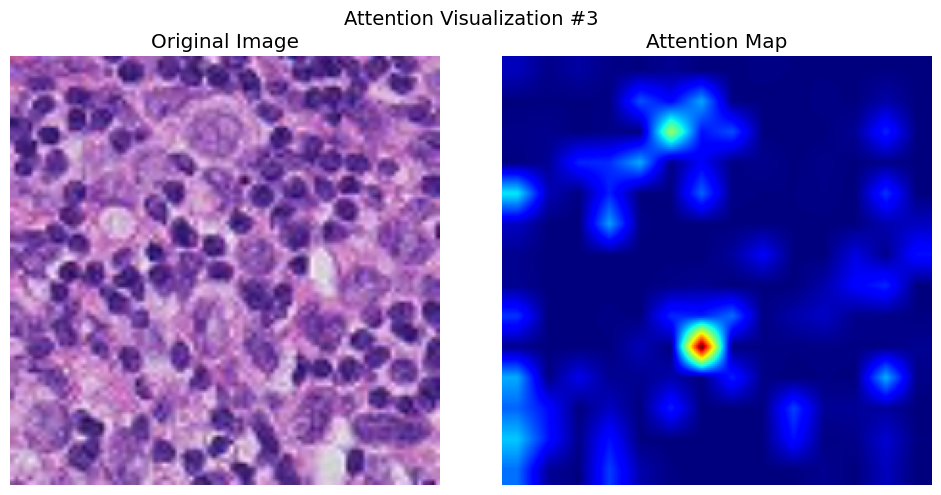

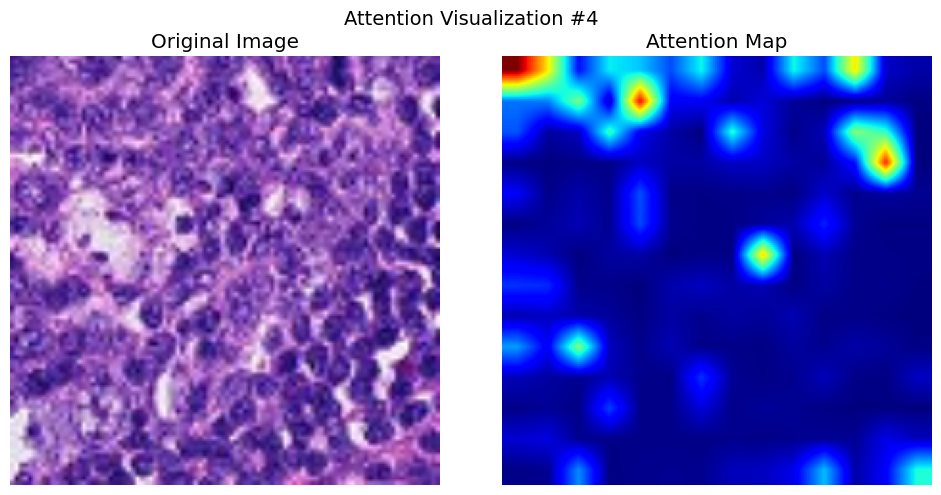

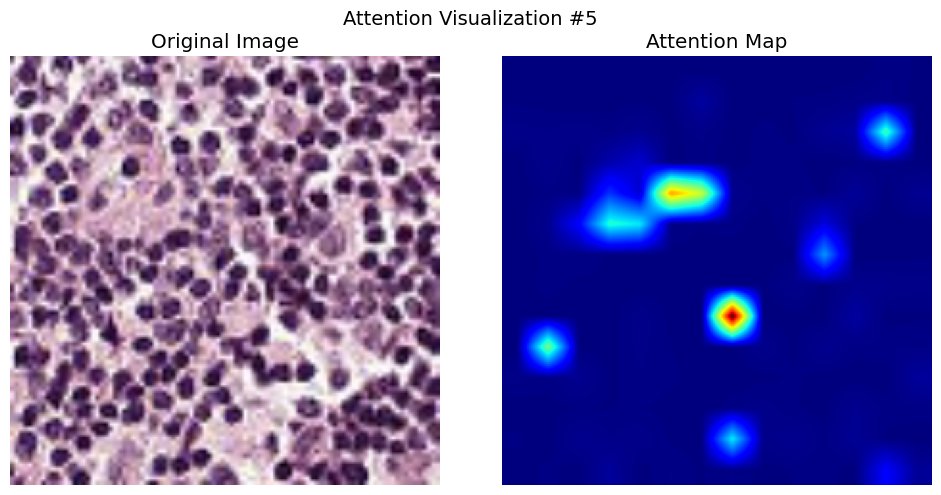

In [18]:
%matplotlib inline
model.eval()

# Lấy 10 mẫu ngẫu nhiên từ test_loader
num_samples = 5
samples = random.sample(range(len(test_data)), num_samples)

# Lặp qua DataLoader để tìm đúng các ảnh
selected = 0
for batch_idx, (images, labels) in enumerate(test_loader):
    batch_start = batch_idx * test_loader.batch_size
    batch_end = batch_start + images.size(0)

    for i in range(images.size(0)):
        global_index = batch_start + i
        if global_index in samples:
            img = images[i]
            x = img.unsqueeze(0).to(device)
            attn_map = get_attention_map(model, x, device)
            visualize_attention(img, attn_map, index=selected + 1)
            selected += 1

            if selected >= num_samples:
                break
    if selected >= num_samples:
        break